In [91]:
### Setting the environment
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt

In [211]:
### Loading data

### From ckan output
source_ckan = pd.read_csv('../data/ckan_output.csv')
source_ckan['Source'] = 'ckan API'

### From google sheets
source_gsheets = pd.read_csv('../data/from_Google_Sheets.csv')
source_gsheets['Source'] = 'manual extraction'

### From arcgis api
source_arcgis = pd.DataFrame()
folder = '../data/arcgis/'
for dirname, _, filenames in os.walk(folder):
    for filename in filenames:
        if filename.rsplit('.',1)[1] == 'csv':
            source_arcgis = source_arcgis.append(pd.read_csv(folder + r'/' + filename))
source_arcgis['Source'] = 'arcgis API'

### Combine all data into single table
data = source_ckan.append(source_gsheets)
data = data.append(source_arcgis)
data = data.reset_index(drop=True)

### Some cleaning
### Remove these irrelevant entries (not councils)
drop_list = ['Development, Safety and Regulation']
data = data[~data['Owner'].isin(drop_list)]
### Renaming entries to match
owner_renames = {
                'Aberdeen': 'Aberdeen City',
                'Dundee': 'Dundee City',
                'Perth': 'Perth and Kinross',
                'open.data@southayrshire':'South Ayrshire'
                }
data['Owner'] = data['Owner'].replace(owner_renames)
### Format dates as datetime type
data['DateUpdated'] = pd.to_datetime(data['DateUpdated'], format='%Y-%m-%d', errors='ignore')

### Output combined data to csv
data.to_csv('../data/merged_output.csv')

### Additional cleaning
### Removed 'Council' from all labels for brevity in visual displays.
data['Owner'] = data['Owner'].str.replace(' Council','')

### New dataset: Distinct datasets by council
data_distinct = data[['Owner','Title','PageURL','Source']]
data_distinct = data_distinct.drop_duplicates()

### Loading list of local authorities (from wikidata)
data_localauthorities = pd.read_csv('../data/local_authorities_list.csv').rename(columns={'itemLabel':'Council'})
data_localauthorities['Council'] = data_localauthorities['Council'].str.replace(' Council','')

### Quality check: These owners in dataset cannot be matched to the appropriate council names
owners = pd.DataFrame(set(data['Owner'])).rename(columns={0:'Owner'})
owners = owners.merge(data_localauthorities, how='left', left_on='Owner', right_on='Council')
qc_owners = owners[owners['Council'].isna()]
if len(qc_owners) > 0:
    print('Quality check: These owners in dataset cannot be matched to the appropriate council names')
    qc_owners
else: None


In [219]:
### default settings for plt graphs
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### function to add data labels
def addlabels(x,y,dp):
    for i in range(len(x)):
        plt.text(i, y[i], round(y[i],dp), ha = 'center')


## Dataset stats

In [212]:
print('all data files: ', len(data))
print('distinct datasets: ', len(data_distinct))

all data files:  794
distinct datasets:  362


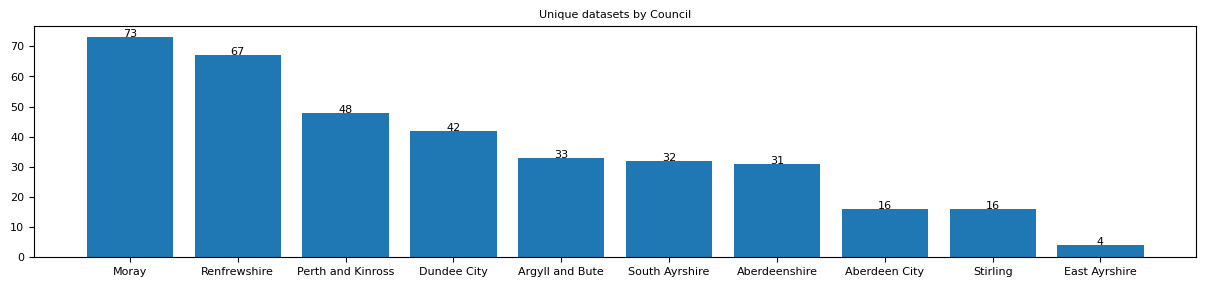

In [221]:
### Unique datasets by council
stats_a = data_distinct.groupby(['Owner']).size().reset_index().rename(columns={0:'Count'})
stats_a = stats_a.sort_values(by=['Count'], ascending=False).reset_index(drop=True)

### Chart
plt.figure(figsize=(15,3))
plt.bar(x=stats_a['Owner'], height=stats_a['Count'])
plt.ylabel(''), plt.xlabel('')
addlabels(stats_a['Owner'], stats_a['Count'],0)
plt.title('Unique datasets by Council')
plt.savefig('Unique datasets by Council.png')
plt.show()


## Dataset Sources

In [50]:
### Unique datasets by Council and Source
stats_b = data_distinct.groupby(['Owner','Source']).size().reset_index().rename(columns={0:'Count'})
stats_b = stats_b.sort_values(by=['Count'], ascending=False).reset_index(drop=True)

### Unique datasets by Council and Source, as matrix
stats_b_pivot = stats_b.pivot(index='Owner',columns='Source', values='Count').reset_index()
stats_b_pivot.loc['Source_Total']= stats_b_pivot.sum(numeric_only=True, axis=0)
stats_b_pivot.loc[:,'Council_Total'] = stats_b_pivot.sum(numeric_only=True, axis=1)
stats_b_pivot

Source,Owner,arcgis,ckan,gsheets,Council_Total
0,Aberdeen,NaN,16.0,NaN,16.0
1,Aberdeenshire,NaN,NaN,31.0,31.0
2,Argyll and Bute,33.0,NaN,NaN,33.0
3,Dundee,NaN,42.0,NaN,42.0
4,East Ayrshire,NaN,NaN,4.0,4.0
5,Moray,62.0,NaN,11.0,73.0
6,Perth,NaN,48.0,NaN,48.0
7,Renfrewshire,67.0,NaN,NaN,67.0
8,South Ayrshire,32.0,NaN,NaN,32.0
9,Stirling,NaN,16.0,NaN,16.0


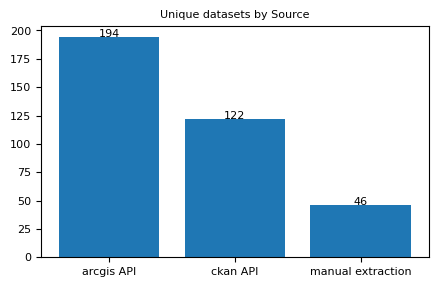

In [214]:
### Unique datasets by Source
stats_b1 = data_distinct.groupby(['Source']).size().reset_index().rename(columns={0:'Count'})
stats_b1 = stats_b1.sort_values(by=['Count'], ascending=False).reset_index(drop=True)

### Chart
plt.figure(figsize=(5,3))
plt.bar(x=stats_b1['Source'], height=stats_b1['Count'])
plt.ylabel(''), plt.xlabel('')
addlabels(stats_b1['Source'], stats_b1['Count'],0)
plt.title('Unique datasets by Source')
plt.savefig('Unique datasets by Source.png')
plt.show()


## Filetypes
There are 25 different filetypes labelled in our dataset but the distribution is very uneven. The clear popular format is the open CSV format, but we also see some proprietary spreadsheet formats such as XLSX and the now depreciated XLS format. 

Bear in mind that several of these files will be duplicated, but in different formats. For example, KMZ is the compressed format of KML. ZIP files may contain several different formats together.


In [140]:
### Table showing counts by filetypes
pd.DataFrame(\
        data.groupby(['FileType']).size())\
    .rename(columns={0:'Count'})\
    .sort_values(by='Count', ascending=False)\
    .reset_index()
    

,FileType,Count
0,CSV,273
1,Feature Layer,158
2,GeoJSON,51
3,HTML,50
4,KML,43
5,ZIP,40
6,Esri REST,30
7,KMZ,28
8,XLSX,22
9,Table,20


We also see inconsitency in filetype metadata. 

There are filetypes labelled "Table", "Image", and "Document Link" which are descriptions rather than names of file formats. All of these come from 1 API and council, and is suggestive of a lack of standardised labelling.

Only 10 of the 24 formats (~40%) are provided by more than 1 council, which again suggests inconsistencies, but this time it could be that the actual filetypes provided are unusual, or it could be labelling errors as before. 

In [180]:
### Table showing number of councils providing each filetypes
data.groupby(['FileType'])['Owner'].nunique()\
    .reset_index()\
    .sort_values(by='Owner', ascending=False)\
    .rename(columns={'Owner':'Count of Councils Providing'})\
    .reset_index(drop=True)

,FileType,Count of Councils Providing
0,CSV,7
1,ZIP,4
2,Feature Layer,4
3,GeoJSON,4
4,KML,3
5,HTML,3
6,PDF,3
7,Esri REST,2
8,XML,2
9,XLSX,2


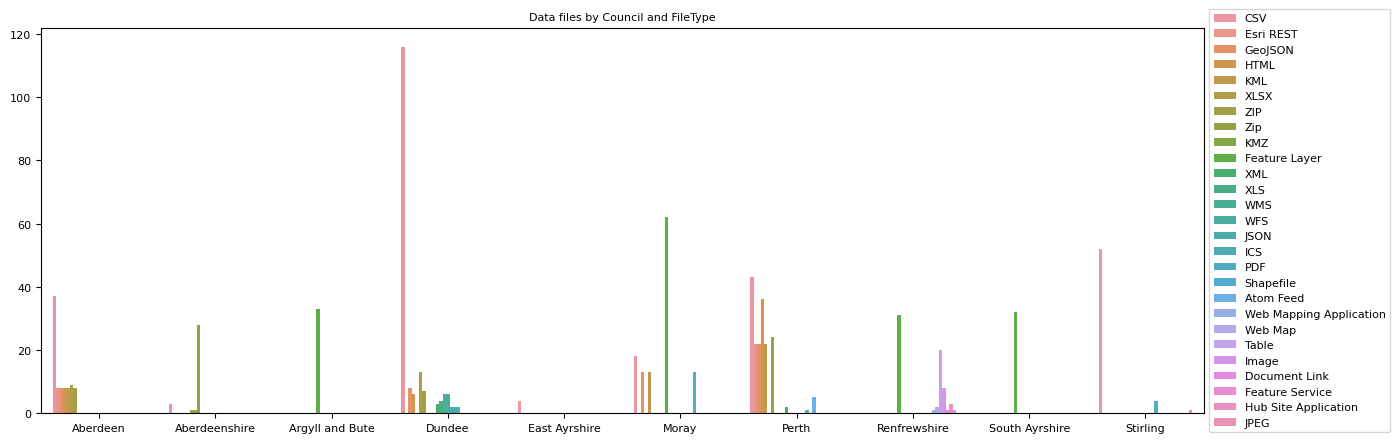

In [161]:
### Count of data files by Council and FileType, ordered by Council name
stats_c = data.groupby(['Owner','FileType']).size().reset_index().rename(columns={0:'Count'})
stats_c = stats_c.sort_values(by=['Owner'], ascending=True).reset_index(drop=True)

### Chart
plt.figure(figsize=(15,5))
sns.barplot(x='Owner', y='Count', data=stats_c, hue='FileType')
plt.ylabel(''), plt.xlabel('')
plt.title('Data files by Council and FileType')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Data files by Council and FileType.png')
plt.show()


In [157]:
### Count of data files by Council and FileType, as matrix (rows=filetype, columns=council), ordered by FileType count
stats_c_pivot = stats_c.pivot(index='FileType',columns='Owner', values='Count')
stats_c_pivot.loc[:,'FileType_Total'] = stats_c_pivot.sum(numeric_only=True, axis=1)
stats_c_pivot = stats_c_pivot.sort_values(by='FileType_Total', ascending=False)
stats_c_pivot.loc['Council_Total']= stats_c_pivot.sum(numeric_only=True, axis=0)
stats_c_pivot

Owner,Aberdeen,Aberdeenshire,Argyll and Bute,Dundee,East Ayrshire,Moray,Perth,Renfrewshire,South Ayrshire,Stirling,FileType_Total
FileType,,,,,,,,,,,
CSV,37.0,3.0,NaN,116.0,4.0,18.0,43.0,NaN,NaN,52.0,273.0
Feature Layer,NaN,NaN,33.0,NaN,NaN,62.0,NaN,31.0,32.0,NaN,158.0
GeoJSON,8.0,NaN,NaN,8.0,NaN,13.0,22.0,NaN,NaN,NaN,51.0
HTML,8.0,NaN,NaN,6.0,NaN,NaN,36.0,NaN,NaN,NaN,50.0
KML,8.0,NaN,NaN,NaN,NaN,13.0,22.0,NaN,NaN,NaN,43.0
ZIP,8.0,1.0,NaN,7.0,NaN,NaN,24.0,NaN,NaN,NaN,40.0
Esri REST,8.0,NaN,NaN,NaN,NaN,NaN,22.0,NaN,NaN,NaN,30.0
KMZ,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0
XLSX,9.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,22.0


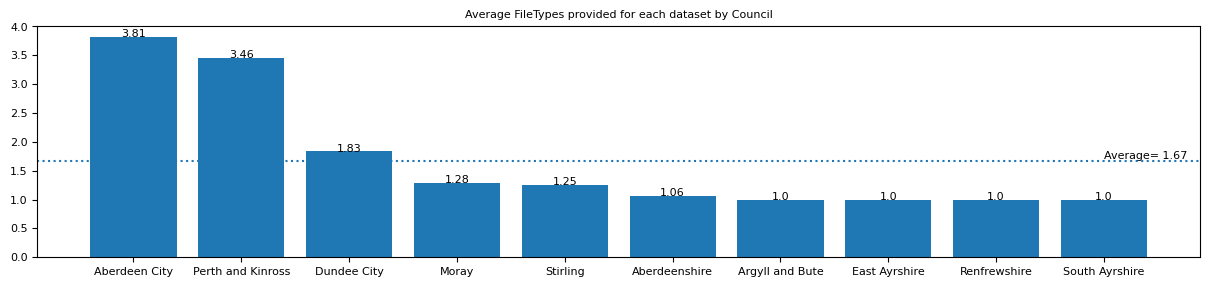

In [236]:
### Average count of filetypes provided per dataset, by council
stats_e = data.groupby(['Owner','Title'])['FileType'].nunique().reset_index()
stats_e = stats_e.groupby(['Owner'])['FileType'].mean().reset_index()
stats_e = stats_e.sort_values(by=['FileType'], ascending=False).reset_index(drop=True)
stats_e_mean = round(stats_e['FileType'].mean(),2)

### Chart
plt.figure(figsize=(15,3))
plt.bar(x=stats_e['Owner'], height=stats_e['FileType'])
plt.ylabel(''), plt.xlabel('')
addlabels(stats_e['Owner'], stats_e['FileType'],2)
plt.axhline(y=stats_e_mean, linestyle=':')
plt.text(x=len(stats_e)-1, y=stats_e_mean, s='Average= '+ str(stats_e_mean), verticalalignment='bottom')
plt.title('Average FileTypes provided for each dataset by Council')
plt.savefig('Average FileTypes provided for each dataset by Council.png')
plt.show()

Bottom line: There is a wide range of filetypes available, but this range is likely due to inconsistencies in labelling rather than in true variety of filetype offerings. The most popular filetype is CSV, which is offered by the most councils and also makes the largest share of all offerings.

## File size

In [292]:
### Convert file size units to bytes
def filesize_convert(unit, val):
    byte_conversions = {
            'bytes': 1,
            'B': 1,
            'KB': 1000,
            'MB': 1000000,
            'GB': 1000000000
        }
    if (unit in list(byte_conversions.keys())) & (val > 0):
        conv_bytes = val * byte_conversions[unit]
    else: 
        conv_bytes = None
        
    return conv_bytes

### apply conversion function
data['filesize_bytes'] = data.apply(lambda x: filesize_convert(x['FileSizeUnit'], x['FileSize']), axis=1)
data['filesize_bins'] = pd.cut(x=data['filesize_bytes'], bins=[1,1000,10000,100000,1000000,10000000, 100000000, 1000000000, 10000000000], labels=['<1KB','1-10KB','10-100KB','0.1-1MB','1-10MB','10-100MB','0.1-1GB','1-10GB'])

### Quality check: instances with no filesize info
filesize_issues = len(data[data['filesize_bytes'].isnull()])
if filesize_issues > 0:
    print('There is no filesize info for ',filesize_issues,' files.')
else: None

There is no filesize info for  92  files.


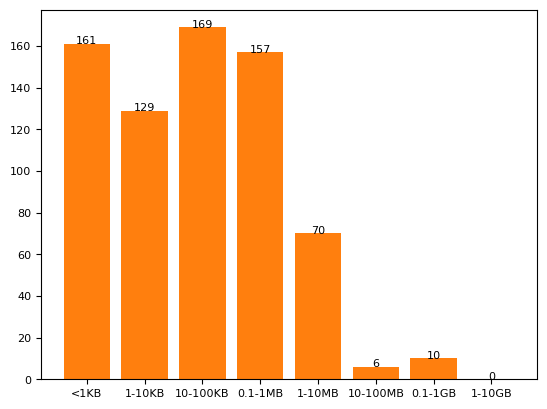

In [304]:
stats_g = data.groupby(['filesize_bins']).size().reset_index()
plt.bar(x=stats_g['filesize_bins'], height=stats_g[0])
addlabels(stats_g['filesize_bins'], stats_g[0],0)
plt.show()


## Dataset Tags

In [54]:
### New dataset: Tags used in the datasets
data_tags = data[['Owner', 'PageURL','OriginalTags','ManualTags']]
data_tags = data_tags.drop_duplicates()

data_tags['AllTags'] = data_tags.apply(lambda x: str(x['OriginalTags'])+ ';' + str(x['ManualTags']), axis=1)
data_tags['AllTags_Tuple'] = data_tags['AllTags'].str.split(';')

stats_d = data_tags[['Owner','AllTags_Tuple']]
'''
plt.figure(figsize=(10,3))
sns.barplot(x='Owner', y='Count', data=stats_c, hue='FileType')
plt.ylabel(''), plt.xlabel('')
#addlabels(stats_c['Owner'], stats_c['Count'])
plt.title('Unique datasets by Council and FileType')
plt.legend(loc='upper right')
plt.show()
'''
stats_d

,Owner,AllTags_Tuple
0,Aberdeen,"[Aberdeen, Contracts, Finance, nan]"
1,Aberdeen,"[Aberdeen, Military, nan]"
12,Aberdeen,"[Academy Catchments, Academy Zones, Boundaries..."
18,Aberdeen,"[Air Quality, Environment, Health, Nitrogen Di..."
24,Aberdeen,"[Aberdeen, Art Gallery, Design, Fashion, Museu..."
...,...,...
62,Renfrewshire,"[Open Data Platform, nan]"
63,Renfrewshire,"[Open Data, Renfrewshire, nan]"
64,Renfrewshire,"[paisley is, nan]"
65,Renfrewshire,"[Open Data, Renfrewshire, nan]"


# Scorecard

- Has an open data portal or site/ has OD content on the site
- Data has been published within the last 1 year, 6 months, 90 days or 30 days
- rank of # filetypes offered
- rank of combined data size
- average file size

In [105]:
# Calculating scores
# Has an OD site
la_withod = set(data['Owner'])

# Last updated
last_update = data.groupby(['Owner'])['DateUpdated'].max().reset_index()
today = dt.datetime.today()
last_update['Days_Passed'] = last_update['DateUpdated'].apply(lambda x: (today - x).days)
#last_365days = [c for c in last_update['Owner'] if last_update ]
last_update['in365'] = last_update['Days_Passed'] < 365
last_update['in180'] = last_update['Days_Passed'] < 180
last_update['in90'] = last_update['Days_Passed'] < 90
last_update['in30'] = last_update['Days_Passed'] < 30
#last_update




,Owner,Council


In [106]:
scorecard = data_localauthorities.copy()
scorecard['Has OD Site'] = scorecard['Council'].isin(la_withod)
scorecard = scorecard.merge(last_update, how='left', left_on='Council', right_on='Owner')
scorecard = scorecard.drop(columns=['DateUpdated','Owner','Days_Passed'])
scorecard = scorecard.fillna(0)
scorecard = scorecard.replace(True, 1)
scorecard = scorecard.replace(False, 0)
scorecard.loc['Score_Total']= scorecard.sum(numeric_only=True, axis=0)
scorecard.loc[:,'Area_Total'] = scorecard.sum(numeric_only=True, axis=1)
scorecard

,Council,Has OD Site,in365,in180,in90,in30,Area_Total
0,Aberdeen City,0.0,0.0,0.0,0.0,0.0,0.0
1,Aberdeenshire,1.0,1.0,1.0,1.0,1.0,5.0
2,Angus,0.0,0.0,0.0,0.0,0.0,0.0
3,Argyll and Bute,1.0,1.0,1.0,1.0,1.0,5.0
4,City of Edinburgh,0.0,0.0,0.0,0.0,0.0,0.0
5,Clackmannanshire,0.0,0.0,0.0,0.0,0.0,0.0
6,Comhairle nan Eilean Siar,0.0,0.0,0.0,0.0,0.0,0.0
7,Dumfries and Galloway,0.0,0.0,0.0,0.0,0.0,0.0
8,Dundee City,0.0,0.0,0.0,0.0,0.0,0.0
9,East Ayrshire,1.0,0.0,0.0,0.0,0.0,1.0
